# Import Modules

In [ ]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from io import BytesIO
import pyperclip
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import shap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import accuracy_score, classification_report

# for clusturing
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

# for XGbost
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier

# Read Files

In [917]:
df_raw = pd.read_csv("data_640_validated.csv", encoding="ISO-8859-1")
df_desc = pd.read_excel("Data description_validated.xlsx")

In [919]:
corr_cols = df_desc[df_desc["Group"]=="5.In-game behavior"]["Question"].to_list()

In [921]:
columns_to_rename = {'How long have you been self-isolated/ social distancing? (please tick "no", if you are not currently self-isolated)': 'Self_isolation',
                     'In overall, how do you feel about the game? [I lost connection with the outside world]':'Feeling Response'}

In [310]:
df_raw = df_raw.rename(columns = columns_to_rename)

# Frequency Comparison

## A comparison of the frequency of the different lengths of being self-isolated/social distancing and game-playing feeling response “I lost connection with the outside world"

In [313]:
freq_table = df_raw[df_raw["Are you currently self-isolated/ social distancing?"]=="Yes"].groupby(['Self_isolation','Feeling Response']).size().reset_index(name='Frequency')

In [315]:
pivot_data = freq_table.pivot(index='Self_isolation', columns='Feeling Response', values='Frequency').fillna(0)

In [317]:
pivot_data

Feeling Response,1,2,3,4,5
Self_isolation,,,,,
1 day,0.0,0.0,0.0,1.0,0.0
4 days,0.0,0.0,2.0,0.0,0.0
5 days,1.0,0.0,0.0,1.0,0.0
6 days,1.0,0.0,0.0,0.0,0.0
7 days,0.0,0.0,0.0,1.0,2.0
More than 2 weeks,3.0,3.0,6.0,15.0,8.0
More than 3 weeks,1.0,6.0,9.0,12.0,12.0
More than a month,59.0,75.0,95.0,79.0,82.0
More than a week,0.0,3.0,5.0,8.0,4.0


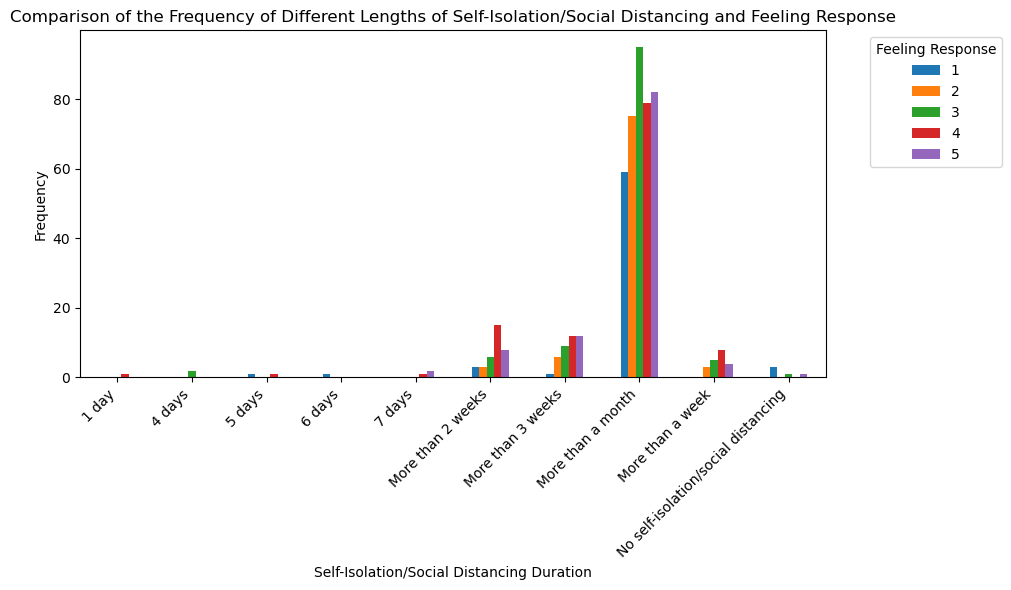

In [319]:
# Plotting
pivot_data.plot(kind='bar', stacked=False, figsize=(10, 6))
plt.title('Comparison of the Frequency of Different Lengths of Self-Isolation/Social Distancing and Feeling Response')
plt.xlabel('Self-Isolation/Social Distancing Duration')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Feeling Response', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [321]:
buf = BytesIO()
plt.savefig(buf, format='png')
buf.seek(0)

# Copy the image to the clipboard
pyperclip.copy(buf.read())

# Close the buffer
buf.close()
plt.close()

## Correlation for Feature selection

In [336]:
# Correlation with self isolation
df_raw['Self_Isolation'] = df_raw['Self_isolation'].map({
    'No self-isolation/social distancing': 0,
    '1 day': 1,
    '6 days': 2,
    '4 days': 3,
    'More than 2 weeks': 4,
    'More than 3 weeks': 5,
    'More than a month': 6
})

In [893]:
numerical_columns_pre = df_raw[corr_cols].fillna(0)

In [895]:
numerical_columns_post = df_raw[["Self_Isolation"]+ corr_cols ].fillna(0)

In [356]:
correlation_matrix = numerical_columns_post.corr()

In [358]:
# Extract the correlation of in-game behavior features with the isolation duration
behavior_columns = numerical_columns_pre.columns.to_list() # example column names

In [360]:
correlation_with_isolation = correlation_matrix['Self_Isolation'][behavior_columns]

In [366]:
correlation_with_isolation.to_clipboard()

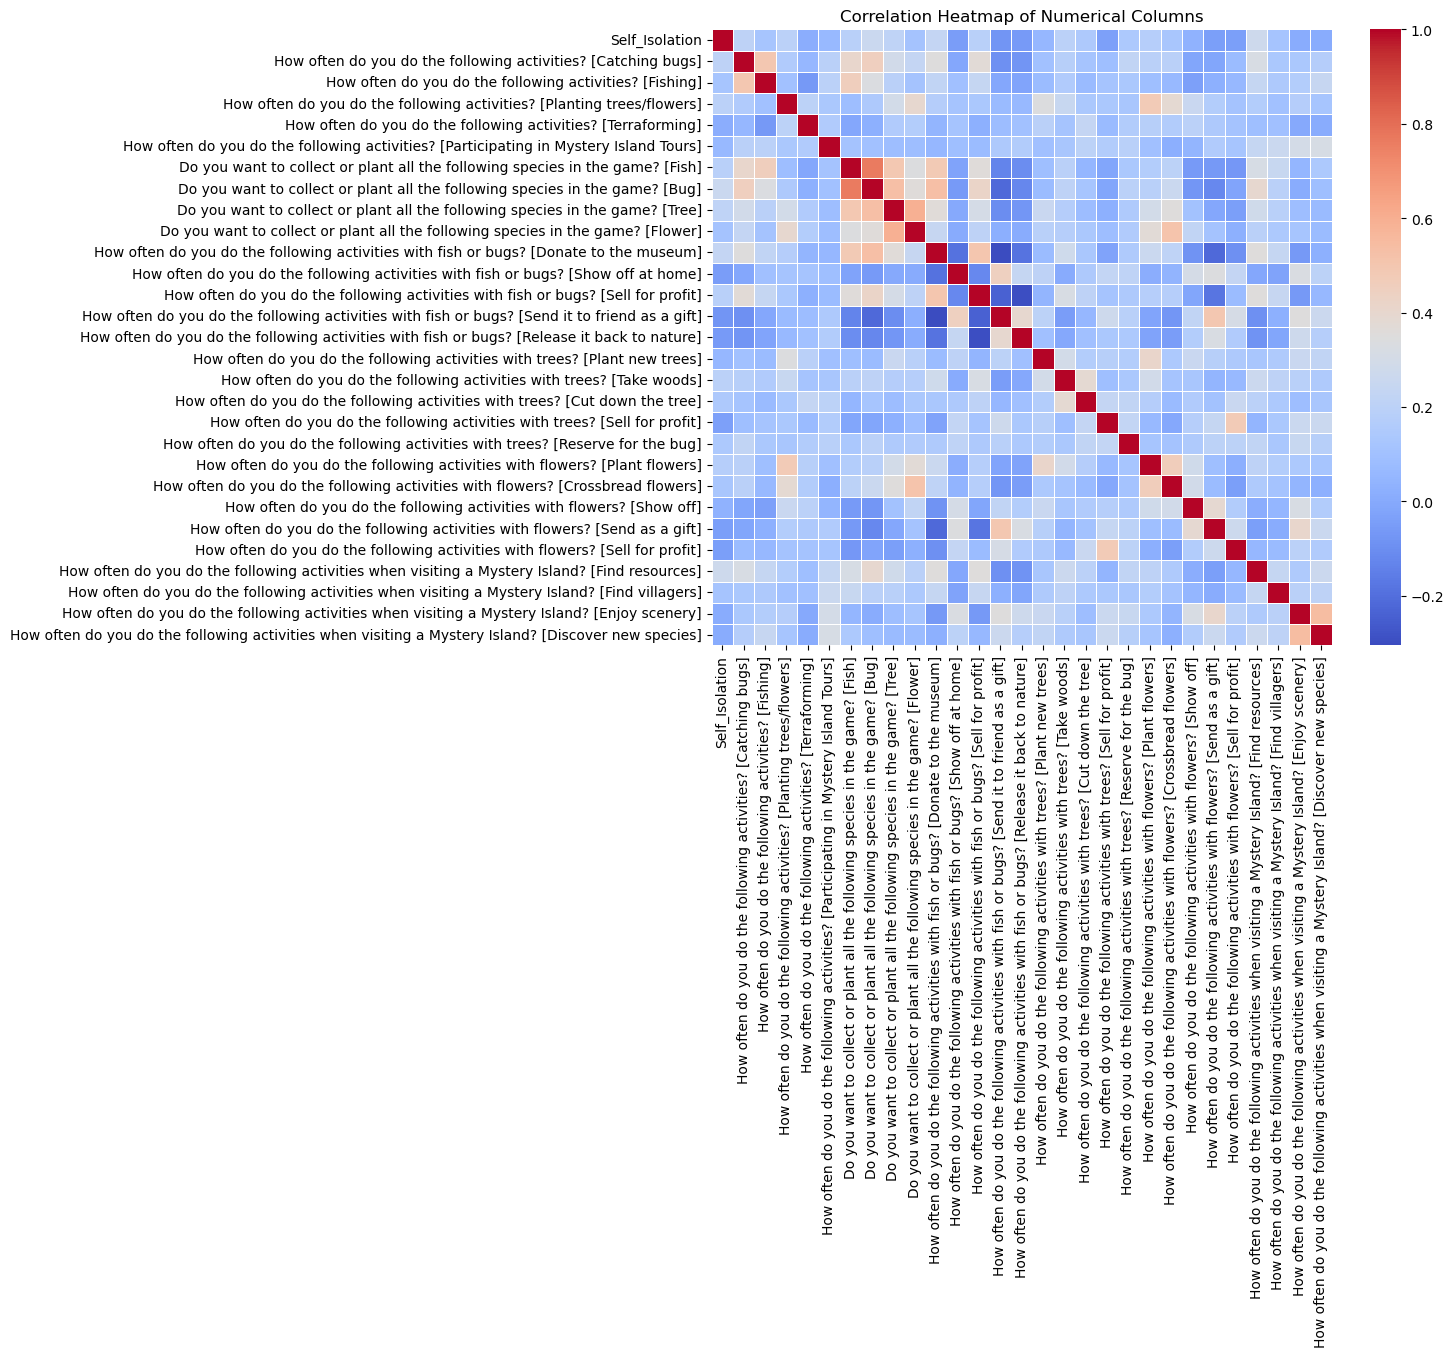

In [364]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Columns')
plt.show()

## Machine learning model for feature selection

In [900]:
numerical_columns_pre = ["How often do you do the following activities when visiting a Mystery Island? [Find resources]",
"How often do you do the following activities with fish or bugs? [Donate to the museum]",
"How often do you do the following activities with trees? [Take woods]",
"How often do you do the following activities with fish or bugs? [Release it back to nature]",
"How often do you do the following activities with fish or bugs? [Show off at home]",
"How often do you do the following activities with trees? [Cut down the tree]"]
numerical_columns_post = ["Self_Isolation","How often do you do the following activities when visiting a Mystery Island? [Find resources]",
"How often do you do the following activities with fish or bugs? [Donate to the museum]",
"How often do you do the following activities with trees? [Take woods]",
"How often do you do the following activities with fish or bugs? [Release it back to nature]",
"How often do you do the following activities with fish or bugs? [Show off at home]",
"How often do you do the following activities with trees? [Cut down the tree]"]

In [856]:
# Assuming 'df' is your dataframe, and 'target' is the column you're predicting
# df_raw.drop(columns = ["Time Period"], inplace = True)
X = df_raw[numerical_columns_pre].fillna(0)
y = df_raw['Self_Isolation'].fillna(0)
model = RandomForestRegressor()
model.fit(X, y)

feature_importance = model.feature_importances_

# Create a dataframe of feature names and their importance
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importance
})

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)

                                             Feature  Importance
3  How often do you do the following activities w...    0.189825
2  How often do you do the following activities w...    0.180842
4  How often do you do the following activities w...    0.173135
5  How often do you do the following activities w...    0.165906
0  How often do you do the following activities w...    0.149940
1  How often do you do the following activities w...    0.140352


In [858]:
feature_importance_df.to_clipboard()

/opt/anaconda3/lib/python3.12/site-packages/shap/plots/_beeswarm.py:950: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  pl.tight_layout()


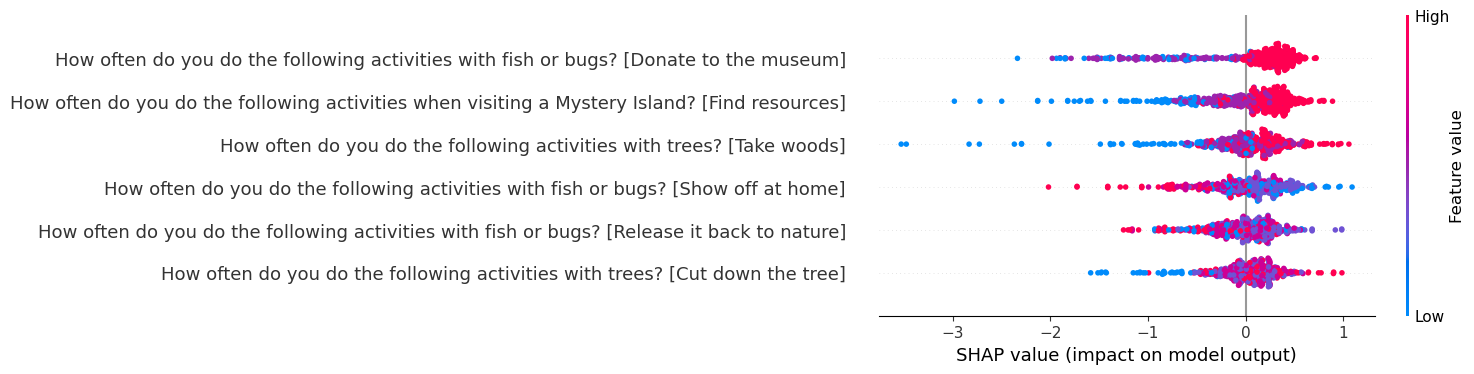

In [860]:
# Initialize SHAP explainer
explainer = shap.TreeExplainer(model)

# Get SHAP values for the training set
shap_values = explainer.shap_values(X)

# Plot SHAP summary plot
shap.summary_plot(shap_values, X)

## Linear Regression Model

In [871]:
np.random.seed(42)
X = df_raw[numerical_columns_pre].fillna(0)
y = df_raw['Self_Isolation'].fillna(0)  # Target variable with noise

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Create and train the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print model coefficients and performance metrics
print("Linear Regression Coefficients:")
print(f"Intercept: {model.intercept_}")
print(f"Coefficient: {model.coef_}")
print("\nModel Performance:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R^2 Score: {r2:.2f}")

Linear Regression Coefficients:
Intercept: 0.34671229649949176
Coefficient: [ 0.55450017  0.4725719   0.38810511 -0.15157057 -0.1840525  -0.00390641]

Model Performance:
Mean Squared Error (MSE): 4.80
Mean Absolute Error (MAE): 1.77
R^2 Score: 0.18


## Polynomial regression

In [691]:
# Example with Polynomial Features
poly = PolynomialFeatures(degree=3)  # You can increase the degree for higher complexity

# Transform features to include polynomial terms
X_poly = poly.fit_transform(X)  # Assuming X is your feature matrix

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

# Create and train the model
poly_model = LinearRegression()
poly_model.fit(X_train, y_train)

# Make predictions
y_pred = poly_model.predict(X_test)

# Evaluate the model
mse_poly = mean_squared_error(y_test, y_pred)
mae_poly = mean_absolute_error(y_test, y_pred)
r2_poly = r2_score(y_test, y_pred)

# Print results
print("Polynomial Regression Performance:")
print(f"Mean Squared Error (MSE): {mse_poly:.2f}")
print(f"Mean Absolute Error (MAE): {mae_poly:.2f}")
print(f"R^2 Score: {r2_poly:.2f}")

Polynomial Regression Performance:
Mean Squared Error (MSE): 4.90
Mean Absolute Error (MAE): 1.78
R^2 Score: 0.16


In [693]:
df_raw[['Self_isolation']+numerical_columns_pre].to_clipboard()

In [695]:
# Label encoding for categorical target
label_encoder = LabelEncoder()
df_raw['Self_isolation'] = label_encoder.fit_transform(df_raw['Self_isolation'])

In [697]:
X = df_raw[numerical_columns_pre]
y = df_raw['Self_isolation']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

## Logistical Regression

In [700]:
log_reg = LogisticRegression(max_iter=100)  # max_iter is set to ensure convergence
log_reg.fit(X_train, y_train)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [702]:
y_pred_log_reg = log_reg.predict(X_test)
print("Accuracy of Logistic Regression:", accuracy_score(y_test, y_pred_log_reg))
print("Classification Report for Logistic Regression:\n", classification_report(y_test, y_pred_log_reg))

Accuracy of Logistic Regression: 0.6640625
Classification Report for Logistic Regression:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         6
           8       0.67      0.96      0.79        83
           9       0.00      0.00      0.00         2
          10       0.56      0.23      0.32        22

    accuracy                           0.66       128
   macro avg       0.14      0.13      0.12       128
weighted avg       0.53      0.66      0.57       128



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Random Forest Classifier

In [705]:
rf_clf = RandomForestClassifier(n_estimators=1000, random_state=42)  # You can tune hyperparameters here
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)
print("Accuracy of Random Forest Classifier:", accuracy_score(y_test, y_pred_rf))
print("Classification Report for Random Forest Classifier:\n", classification_report(y_test, y_pred_rf))

Accuracy of Random Forest Classifier: 0.65625
Classification Report for Random Forest Classifier:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         6
           8       0.69      0.95      0.80        83
           9       0.00      0.00      0.00         2
          10       0.56      0.23      0.32        22

    accuracy                           0.66       128
   macro avg       0.14      0.13      0.12       128
weighted avg       0.54      0.66      0.57       128



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Clusturing the data

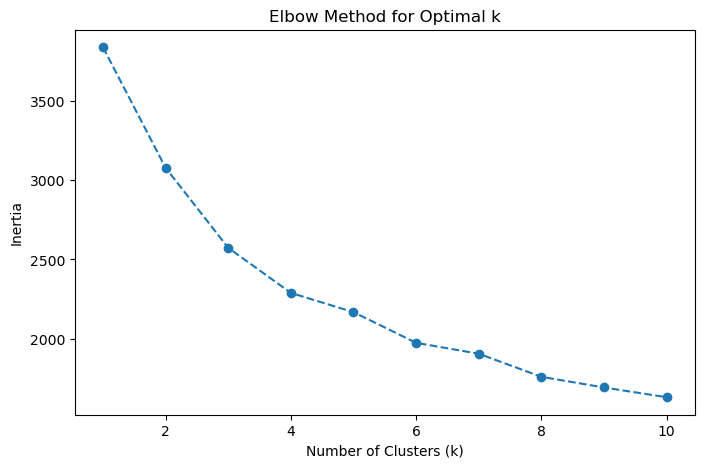

In [820]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_raw[numerical_columns_pre])

# Determine the optimal number of clusters using the Elbow Method
inertia = []
range_clusters = range(1, 11)

for k in range_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(range_clusters, inertia, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

Silhouette Score: 0.19


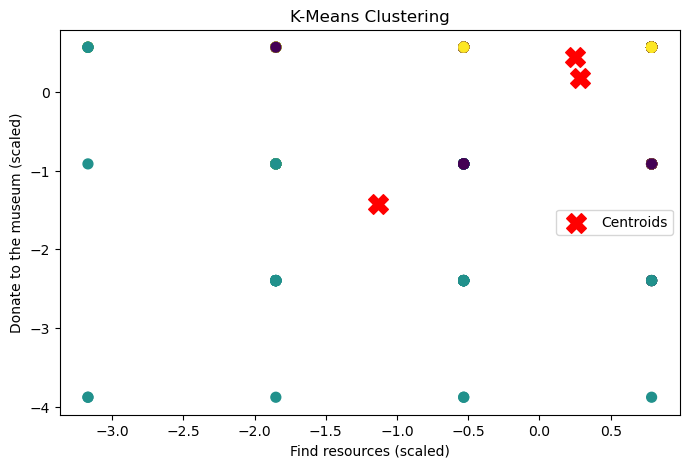

In [839]:
# Apply K-Means Clustering with optimal k (choose from elbow plot)
optimal_k = 3 # Choose based on the elbow plot
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Add cluster labels to the original dataframe
df_raw['Cluster'] = clusters

# Evaluate clustering performance with Silhouette Score
sil_score = silhouette_score(X_scaled, clusters)
print(f"Silhouette Score: {sil_score:.2f}")

# Visualize the clusters (2D plot using two features)
plt.figure(figsize=(8, 5))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, cmap='viridis', s=50)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='X', s=200, label='Centroids')
plt.xlabel('Find resources (scaled)')
plt.ylabel('Donate to the museum (scaled)')
plt.title('K-Means Clustering')
plt.legend()
plt.show()

In [841]:
df_model = df_raw[numerical_columns_pre+["Cluster"]]

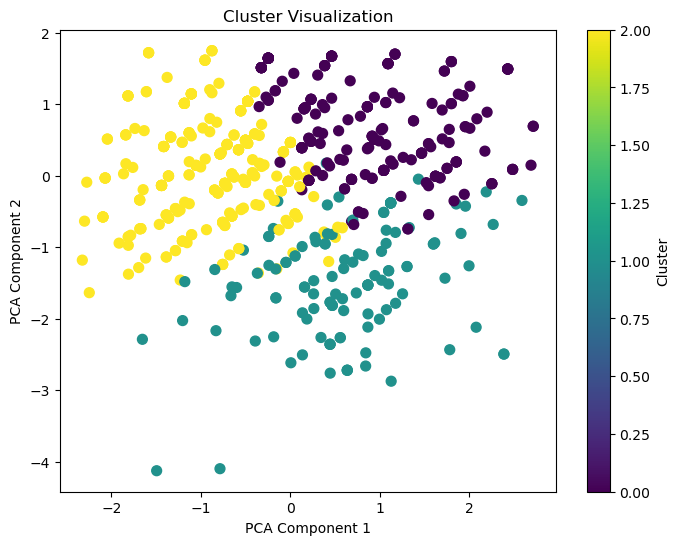

In [843]:
# df_raw['Cluster'] = kmeans.labels_

# # Profile each cluster
# cluster_profiles = df_raw.groupby('Cluster').mean()  # Replace 'mean' with other stats if needed
# print(cluster_profiles)



# Visualize clusters (2D using PCA)
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_model.drop('Cluster', axis=1))

plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=df_model['Cluster'], cmap='viridis', s=50)
plt.title('Cluster Visualization')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

<Figure size 640x480 with 0 Axes>

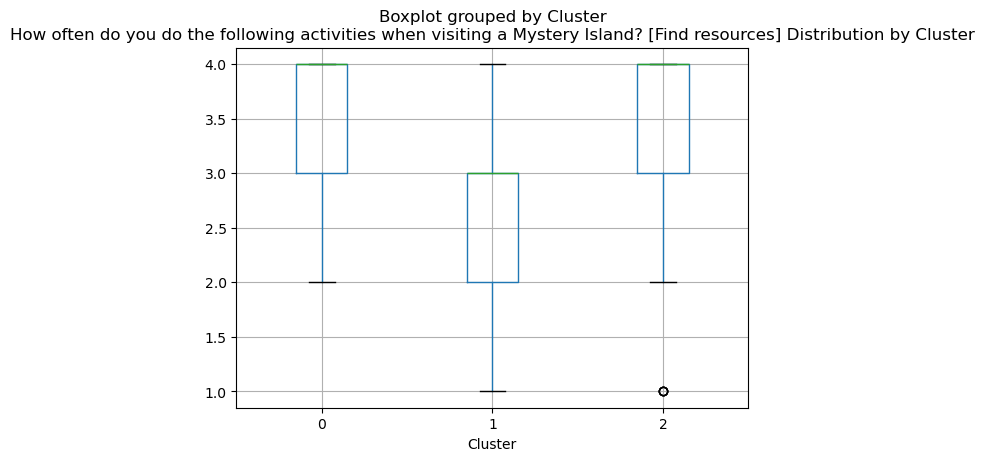

<Figure size 640x480 with 0 Axes>

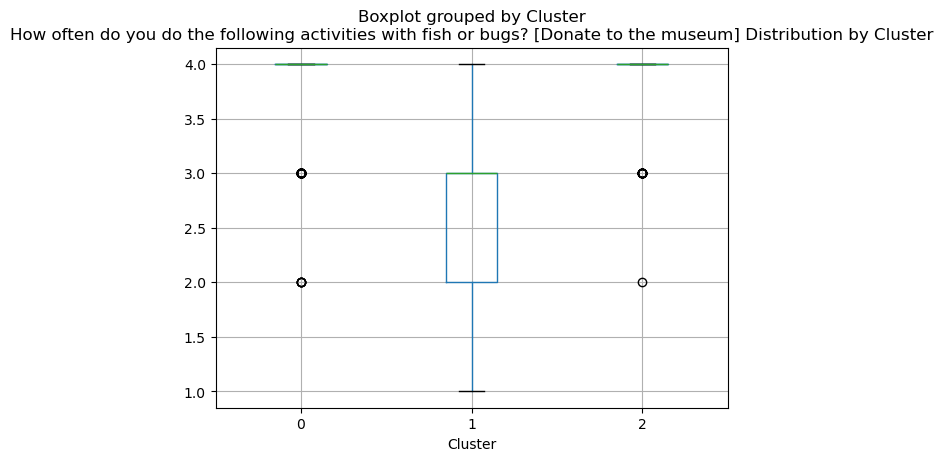

<Figure size 640x480 with 0 Axes>

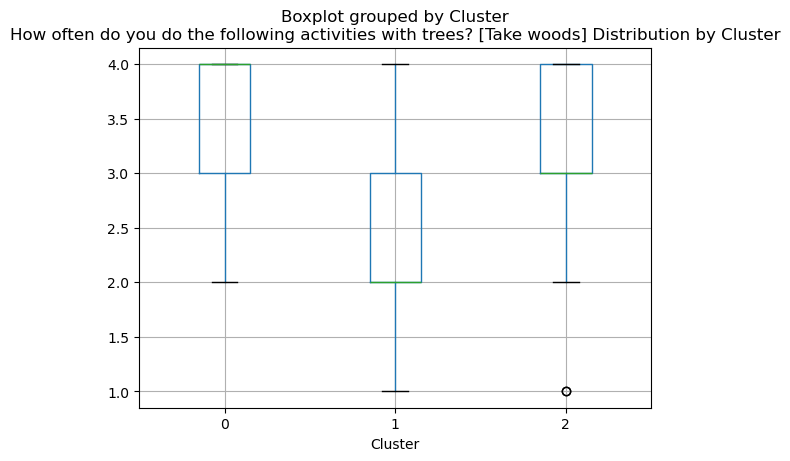

<Figure size 640x480 with 0 Axes>

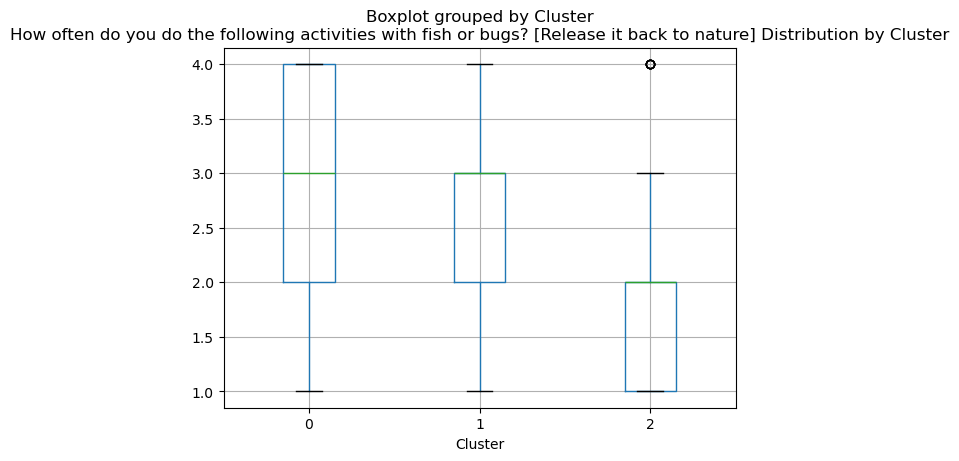

<Figure size 640x480 with 0 Axes>

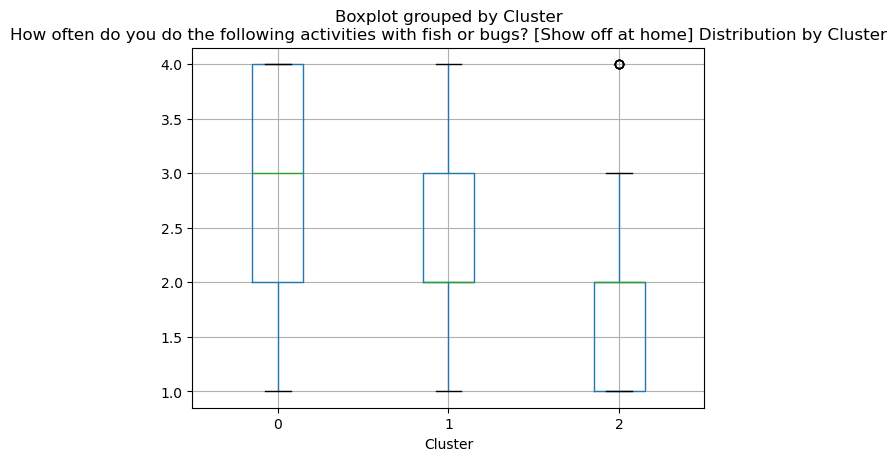

<Figure size 640x480 with 0 Axes>

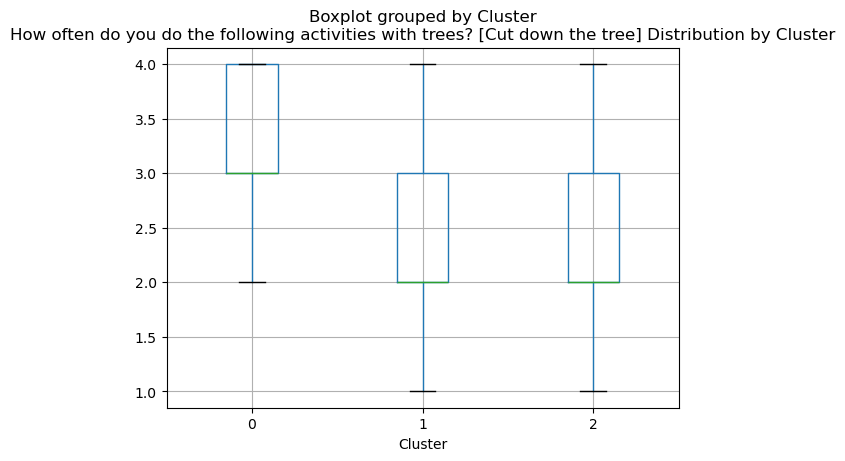

In [845]:
# Example: Feature distribution by cluster
for col in df_model.columns[:-1]:  # Exclude 'Cluster' column
    plt.figure()
    df_model.boxplot(column=col, by='Cluster')
    plt.title(f'{col} Distribution by Cluster')
    plt.show()

In [850]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Example: Using 'Cluster' as a feature for predicting 'self_isolation'
X = df_raw[numerical_columns_post+["Cluster"]].drop('Self_Isolation', axis=1).fillna(0)  # Features (including 'Cluster')
y = df_raw['Self_Isolation'].fillna(0)  # Target variable

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Train a Random Forest Classifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Model Accuracy: {accuracy:.2f}')

Model Accuracy: 0.63


In [833]:
# Evaluate the model
mse_poly = mean_squared_error(y_test, y_pred)
mae_poly = mean_absolute_error(y_test, y_pred)
r2_poly = r2_score(y_test, y_pred)

# Print results
print("Polynomial Regression Performance:")
print(f"Mean Squared Error (MSE): {mse_poly:.2f}")
print(f"Mean Absolute Error (MAE): {mae_poly:.2f}")
print(f"R^2 Score: {r2_poly:.2f}")

Polynomial Regression Performance:
Mean Squared Error (MSE): 9.53
Mean Absolute Error (MAE): 1.76
R^2 Score: -0.64


In [753]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Silhouette Score
silhouette_avg = silhouette_score(df_model.drop('Cluster', axis=1), df_model['Cluster'])
print(f'Silhouette Score: {silhouette_avg:.2f}')

# Davies-Bouldin Index
db_score = davies_bouldin_score(df_model.drop('Cluster', axis=1), df_model['Cluster'])
print(f'Davies-Bouldin Index: {db_score:.2f}')

Silhouette Score: 0.44
Davies-Bouldin Index: 1.12


In [852]:
df_raw.to_clipboard()

## XG Boost Model

In [985]:
target_column = 'How long have you been self-isolated/ social distancing? (please tick "no", if you are not currently self-isolated)'
df_model = df_raw[[target_column]+numerical_columns_pre]
df_model.columns = df_model.columns.str.replace(r"[\/?[\]<>{}(),]+", "", regex=True).str.strip()

In [987]:
df_model.columns

Index(['How long have you been self-isolated social distancing please tick "no" if you are not currently self-isolated',
       'How often do you do the following activities when visiting a Mystery Island Find resources',
       'How often do you do the following activities with fish or bugs Donate to the museum',
       'How often do you do the following activities with trees Take woods',
       'How often do you do the following activities with fish or bugs Release it back to nature',
       'How often do you do the following activities with fish or bugs Show off at home',
       'How often do you do the following activities with trees Cut down the tree'],
      dtype='object')

In [1001]:
from imblearn.over_sampling import SMOTE

target_column = 'How long have you been self-isolated social distancing please tick "no" if you are not currently self-isolated'

# Encode the target column
le = LabelEncoder()
df_model[target_column] = le.fit_transform(df_model[target_column])

# Define features (X) and target (y)
X = df_model.drop(columns=[target_column])
y = df_model[target_column]

# Step 1: Check class distribution
class_counts = pd.Series(y).value_counts()
print("Class distribution before handling rare classes:")
print(class_counts)

# Step 2: Remove or combine rare classes if necessary
min_class_count = 2  # Define the minimum count for each class
rare_classes = class_counts[class_counts < min_class_count].index

if len(rare_classes) > 0:
    print(f"Rare classes identified: {rare_classes.tolist()}")
    
    # Option A: Remove rare classes
    filtered_df_model = df_model[~df_model[target_column].isin(rare_classes)]
    
    # Option B: Combine rare classes into a single "Other" category
    # Uncomment this section if you prefer combining rare classes
    df_model[target_column] = df_model[target_column].apply(
        lambda x: -1 if x in rare_classes else x  # Use -1 for "Other"
    )

    # Update X and y after filtering or combining
    X = filtered_df_model.drop(columns=[target_column])
    y = filtered_df_model[target_column]
    print("Class distribution after handling rare classes:")
    print(pd.Series(y).value_counts())

# Handle class imbalance using SMOTE or Random Oversampling
try:
    # Use SMOTE with k_neighbors=1
    smote = SMOTE(random_state=42, k_neighbors=1)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    print("Resampling completed with SMOTE.")
except ValueError as e:
    print("SMOTE failed. Switching to Random Oversampling...")
    ros = RandomOverSampler(random_state=42)
    X_resampled, y_resampled = ros.fit_resample(X, y)

# Stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.20, stratify=y_resampled, random_state=42
)

# Verify classes are consecutive integers
unique_classes = sorted(y_resampled.unique())
print(f"Classes after resampling: {unique_classes}")

if min(unique_classes) != 0 or max(unique_classes) != len(unique_classes) - 1:
    # Re-encode to ensure consecutive integer labels
    label_encoder = LabelEncoder()
    y_train = label_encoder.fit_transform(y_train)
    y_test = label_encoder.transform(y_test)

# Train XGBoost classifier
xgb = XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric="mlogloss",  # Avoid warning for deprecated label encoding
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5
)

xgb.fit(X_train, y_train)

# Make predictions
y_pred = xgb.predict(X_test)

# Evaluate model
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

/var/folders/6_/lnnlyvg97bv1fbtwyqqth9z80000gn/T/ipykernel_5643/209683777.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model[target_column] = le.fit_transform(df_model[target_column])
/var/folders/6_/lnnlyvg97bv1fbtwyqqth9z80000gn/T/ipykernel_5643/209683777.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model[target_column] = df_model[target_column].apply(
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [22:55:55] WARNING: /Users/runner/work/xgboost/xgboost/s

Class distribution before handling rare classes:
How long have you been self-isolated social distancing please tick "no" if you are not currently self-isolated
8     403
10    111
7      45
6      42
9      20
5       7
1       4
2       3
3       2
4       2
0       1
Name: count, dtype: int64
Rare classes identified: [0]
Class distribution after handling rare classes:
How long have you been self-isolated social distancing please tick "no" if you are not currently self-isolated
8     403
10    111
7      45
6      42
9      20
5       7
1       4
2       3
3       2
4       2
Name: count, dtype: int64
Resampling completed with SMOTE.
Classes after resampling: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Model Accuracy: 0.84

Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        80
           1       1.00      1.00      1.00        80
           2       0.94      0.99      0.96        81
           3       0.82      0.99    

In [1003]:
# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae:.2f}")

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# R-squared (R^2)
r2 = r2_score(y_test, y_pred)
print(f"R-squared (R^2): {r2:.2f}")

Mean Absolute Error (MAE): 0.37
Root Mean Squared Error (RMSE): 1.19
R-squared (R^2): 0.83


In [2]:
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Ensure labels are consecutive integers
label_encoder = LabelEncoder()
y_resampled_encoded = label_encoder.fit_transform(y_resampled)

# Step 2: Apply PCA transformation to features
pca = PCA(n_components=0.95, random_state=42)  # Retain 95% of variance
X_pca = pca.fit_transform(X_resampled)

# Step 3: Hyperparameter tuning for XGBoost
param_dist = {
    "n_estimators": [50, 100, 200],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1, 0.2],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
}

xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric="mlogloss")
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=20,
    scoring="accuracy",
    cv=3,
    random_state=42,
    verbose=1
)

random_search.fit(X_pca, y_resampled_encoded)
best_model = random_search.best_estimator_

# Step 4: Train-test split
X_train_pca, X_test_pca, y_train, y_test = train_test_split(
    X_pca, y_resampled_encoded, test_size=0.25, stratify=y_resampled_encoded, random_state=42
)

# Train the best model
best_model.fit(X_train_pca, y_train)

# Step 5: Evaluate the model
y_pred = best_model.predict(X_test_pca)

# Decode predicted and actual labels back to original
y_test_decoded = label_encoder.inverse_transform(y_test)
y_pred_decoded = label_encoder.inverse_transform(y_pred)

# Classification report and accuracy
accuracy = accuracy_score(y_test_decoded, y_pred_decoded)
print(f"Model Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(y_test_decoded, y_pred_decoded))

# Confusion matrix
conf_matrix = confusion_matrix(y_test_decoded, y_pred_decoded)
print("\nConfusion Matrix:")
print(conf_matrix)

# Step 6: Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

NameError: name 'y_resampled' is not defined

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
import pandas as pd

# Target column
target_column = 'How long have you been self-isolated social distancing please tick "no" if you are not currently self-isolated'

# Encode the target column
le = LabelEncoder()
df_model[target_column] = le.fit_transform(df_model[target_column])

# Define features (X) and target (y)
X = df_model.drop(columns=[target_column])

# df_model consist of the column with selected features and target column
y = df_model[target_column]

# Check class distribution
class_counts = pd.Series(y).value_counts()
print("Class distribution before resampling:")
print(class_counts)

# Handle class imbalance using SMOTE
try:
    # Apply SMOTE to balance the dataset
    smote = SMOTE(random_state=42, k_neighbors=1)

    # Kept k_neighbours as 1 as it was showing skewed results for values>1
    X_resampled, y_resampled = smote.fit_resample(X, y)

    print("Resampling completed with SMOTE.")
except ValueError as e:
    # Handle SMOTE errors (fallback to Random Oversampling if necessary)
    print("SMOTE failed. Switching to alternative resampling...")
    ros = RandomOverSampler(random_state=42)
    X_resampled, y_resampled = ros.fit_resample(X, y)

# Stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.25, stratify=y_resampled, random_state=42
)

# Train XGBoost classifier
xgb = XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric="mlogloss",  # Prevent warnings about label encoding
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5
)
xgb.fit(X_train, y_train)

# Make predictions
y_pred = xgb.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae:.2f}")

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# R-squared (R^2)
r2 = r2_score(y_test, y_pred)
print(f"R-squared (R^2): {r2:.2f}")

